# Quantum string matching using Grover's algorithm 

*Author*: Júlia Barberà, 21st May of 2022

This notebook presents a code to find a pattern in a given string using Grover's algorithm based on the article: 
"Quantum Pattern Matching" by P. Mateus and Y. Omar (eprint: [arXiv:quant-ph/0508237](https://arxiv.org/abs/quant-ph/0508237)).

For computational reasons, it simulates the solution for a string of length $N = 8$ and a pattern of length $M = 2$. 

The code is written using [Qibo](https://qibo.readthedocs.io/en/stable/) language and qibojit simulator as a default backend.

__Table of contents:__
1. [Quantum string matching](#quantum-string-matching)
    1. [State initialization](#state-initialization)

2. [Grover's algorithm](#grover's-algorithm)
    1. [Grover's Oracle](#grover's-oracle)
    1. [Diffusion operator](#diffusion-operator)
    
    
3. [Extra functions](#extra-functions)
    1. [Binary to decimal](#binary-to-decimal)
    1. [Decimal to binary](#decimal-to-binary)
    

4. [Main code: Quantum string matching algorithm](#Main-code-quantum-string-matching-algorithm)
    1. [Quantum string matching](#quantum-string-matching)
    1. [Comparison with classical algorithms](#comparison-with-classical-algorithms)
    1. [Plots](#plots)
    

In [84]:
## Import all libraries that we will need
import math as m
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt
import operator
import itertools

## Quantum string matching

The problem of finding occurrence of a pattern string within another string can be solved using Grover's algorithm. 
Let's assume that we want to find where the pattern $|p\rangle$ of size M occurs within the string $|w\rangle$ of size N. In order to return the position $|i\rangle \in N$ we have to encode the position in a unit vector of a Hilbert subspace of dimension N: $|i\rangle = \{ |1\rangle, ...,|N\rangle\}$. 

Given the pattern p, if we consider that its length is $M = 2$, the second match will have to occur just after the first one. Therfore, the possible solutions of the problem have to represent an entangled state $|i\rangle\otimes|i +1\rangle$ which the first state corresponds to the first index where the first pattern's character is found and the second state is the location of the second character of the given pattern within the given string.  

Consequently, the initial state for the index consists of a uniform superposition of all the possible solutions expressed like:

<br>

<center> $\psi_0 =\frac{1}{\sqrt{N}}\sum^{N-1}_{i = 0}(|i\rangle + |i +1\rangle,...,|i + M - 1 \rangle). $ </center>

<br>

The number of qubits that are used to represent the index states is $s = log_2(N - M)$ for each index $|i\rangle$. 
The total circuit, thus, will consist in a Hilbert space of dimension $d = N + M + 2\cdot s$. 
Once the initial state is prepared, the Grover's oracle $U_\sigma$ has to act over all the states. This oracle acts like a black box which marks (with a phase flip of $-1$) the state that is the solution: 

<br>

<center> $U_\sigma(|i\rangle \otimes |i +1\rangle) = (-1)^{f_\sigma (i)}(|i\rangle \otimes |i +1\rangle),$ </center>

<br>
with, $ f_\sigma (i) = 1$ if the i-th character of $|w\rangle$ is $\sigma$ (in our case $\sigma ={0,1}$) and $ f_\sigma (i) = 0$ otherwise. After applying the oracle, the states which tell where the match has occurred will be flipped. 
The next step is to amplify the states that are solution using Grover's diffusion operator expressed in a general form as: 

<br>

<center> $U_w = (2|\psi\rangle \langle \psi| - I )$. </center> 

<br> 

When we measure, we will find that the state with the highest probability is the one that tells the location of the pattern within the string. 

The algorithm anatomy is presented below: 

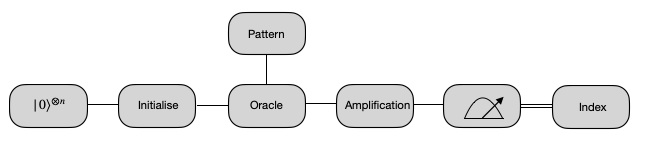

### State initialization

To create the initial entangled state for a case with $N = 8 $ and $M = 2 $: 

<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ), $ </center>

<br>
we have to proceed as follows: 

- Firstly, initiate the circuit to $|0\rangle^{\otimes 6}$ using $s = log_2(N - M)$ qubits for each letter of the pattern, in our case 6.  
-  Apply hadamards to the first set of qubits (3 qubits) in order to have a superposition of all the index: $|0\rangle...|i\rangle$. This state will result in: 

<br>

<center> $|\psi\rangle =\frac{1}{2\sqrt{2}}(|000\rangle +|001\rangle +|010\rangle +|011\rangle +|100\rangle +|101\rangle +|110\rangle +|111\rangle ) \otimes |000\rangle$. </center>

<br>

- Entangle the the first set of qubits with the second one using CNOT gates to obtain the state: $|\psi'\rangle =\frac{1}{\sqrt{N}}\sum_{i = 1}^7 (|i\rangle \otimes |i\rangle ). $

- Increment the index of the second set of qubits by 1, using MCX gates to obtain the initial state: 
<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ). $ </center>

<br>

Notice that we have considered periodic boundary conditions because if we don't we would need an extra qubit and it gets more complex to create the initial state only using MCX gates. 

The circuit initialization diagram is shown below. 

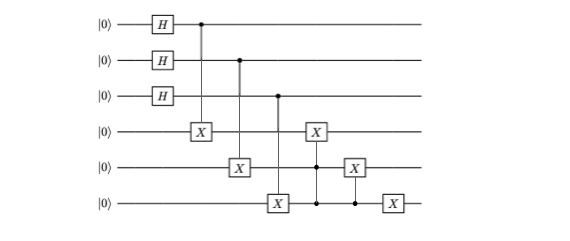

In [98]:
def initialize( N, M, s, string_w, pattern_p):
    for i in range(N): 
        if string_w[i] == 1: 
            c.add(gates.X(i))

    for i in range(M): 
        if pattern_p[i] == 1: 
            c.add(gates.X(i + N))

    # entanglement 
    for i in range(int(s/2)):
        c.add(gates.H(i + N + M))

    for i in range(int(s/2)):
        c.add(gates.CNOT(i + N + M,i + int(s/2) + N + M))

    for i in range(int(s/2)): 
        if i == (int(s/2)-1):
            c.add(gates.X(N + M + s - 1))
        else:
            c.add(gates.X(int(s/2) + i + N + M).controlled_by(*range(int(s/2) + i + N + M + 1, N + M + s)))

    return c

## Grover's algorithm

Grover's algorithm is used for unsorted data search problems and as a consequence we can express a quantum string search problem in a way that Grover's algorithm can be applied to find the solution. 
This algorithm is composed by an oracle which has the function to mark the solution state and a diffusion operator needed to amplify this state in order to measure it with the highest probability amond the other ones. 

### Grover's Oracle: $U_\sigma$

This kind of problem involves as many oracles as letters our alphabet has. In other words, for every different character of the pattern (i.e. 0 and 1 for our case) we need to construct a different oracle. 

Let's consider the case: 
<center> $|w\rangle$ = $|11100000\rangle$ and  $|p\rangle$ = $|10\rangle$. 
    
Our alphabet will be composed by two characters because we are using binary: $\Sigma = \{0,1\}$. We have to see where this pattern is. It can be done following the next steps:
    

1. Take the first character of the pattern: $\sigma = 1 $, to see if there is a match with the rest of characters of the string $|w\rangle$. 
    
2. Compare $\sigma$ with the rest components of $|w\rangle$. If they are equal, as will happend for index 0,1 and 2, we have to mark the state where the match is produced like: 
<center> $U_{\sigma(1)} \psi = \frac{1}{2\sqrt{2}}(-|0,1\rangle -|1,2\rangle -|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ) $

Now we should do the same with the second letter of the alphabet. However, with some combinations of the string $|w\rangle$ and $|p\rangle$ we can have problems as there can be more than one state that has not been marked and has the same sign as the solution. As a consequence, we will apply the diffusion operator every time one of the oracles is applied to the states in order to see a higher amplification of the solution. 
        
    
We will have to apply every oracles as many times as the letter of the alphabet $\sigma$ happens in the pattern $|p\rangle$. For this case we will only have to apply each alphabet one time. 

    
- For the first letter of the pattern, the states will be marked using a MCZ gate with the last qubit of the set of $s$ qubits as the target, once the state that has a match is moved to the last entry. The controls will be each qubits of the string and the qubit that represents the first letter of the pattern. If they are equal, the state will be flipped. When the MCZ gate is applied and the state is flipped, we bring the state to its original position. 
    
- The same will happen for the second letter. However, for this case we will have to consider the second set of qubits $s$ which represents the second index. If there is a match between the pattern and the string, the state that represents the second index will be flipped and brought to its original position. 

In [212]:
def oracle_1(N,M,s):
    
    #Creates list of all combinations that can be made with different length 
    inp_list = [*range(N + M, N + M + int(s/2))]
    combi = [ ]
    controls = [3, 5, 6, 1, 2, 4, 0]
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    for i in range(len(combi)+1):
        if  i == len(combi): 
            c.add(gates.Z(N + M + 2).controlled_by(N-1, N, N + M, N + M + 1))
        else: 
            c.add([gates.X(j) for j in list(combi[i])])
            c.add(gates.Z(N + M + 2).controlled_by(controls[i], N, N + M, N + M + 1))
            c.add([gates.X(j) for j in list(combi[i])])
    diffusion(N, M, s)
    #Creates list of all combinations that can be made with different length 
    inp_list = [*range(N + M + int(s/2), N + M + s)]
    combi = [ ]
    controls = [3, 5, 6, 1, 2, 4, 0]
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    for i in range(len(combi)+1):
        if  i == len(combi): 
            c.add(gates.Z(N + M + 5).controlled_by(0, N + 1, N + M + 3, N + M + 4))
        else: 
            c.add([gates.X(j) for j in list(combi[i])])
            c.add(gates.Z(N + M + 5).controlled_by(controls[i] , N + 1, N + M + 3, N + M + 4))
            c.add([gates.X(j) for j in list(combi[i])])
    diffusion(N, M, s)
    return c


In [213]:
def oracle_0(N,M,s):

    
    #Creates list of all combinations that can be made with different length 
    inp_list = [*range(N + M, N + M + int(s/2))]
    combi = [ ]
    controls = [3, 5, 6, 1, 2, 4, 0]
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    for i in range(len(combi)+1):
        if  i == len(combi):                  
            c.add(gates.X(N - 1))
            c.add(gates.X(N))
            c.add(gates.Z(N + M + 2).controlled_by(N-1, N, N + M, N + M + 1))
            c.add(gates.X(N - 1))
            c.add(gates.X(N))
        else: 
            c.add([gates.X(j) for j in list(combi[i])])
            c.add(gates.X(controls[i]))
            c.add(gates.X(N))
            c.add(gates.Z(N + M + 2).controlled_by(controls[i], N, N + M, N + M + 1))
            c.add(gates.X(controls[i]))
            c.add(gates.X(N))
            c.add([gates.X(j) for j in list(combi[i])])
    diffusion(N, M, s)
    #Creates list of all combinations that can be made with different length 
    inp_list = [*range(N + M + int(s/2), N + M + s)]
    combi = [ ]
    for i in range(1, len(inp_list) + 1):
        combi.extend(list(itertools.combinations(inp_list, r = i)))
        
    for i in range(len(combi)+1):
        if  i == len(combi): 
            c.add(gates.X(0))
            c.add(gates.X(N + 1))
            c.add(gates.Z(N + M + 5).controlled_by(0, N + 1, N + M + 3, N + M + 4))
            c.add(gates.X(0))
            c.add(gates.X(N + 1))
        else: 
            c.add([gates.X(j) for j in list(combi[i])])
            c.add(gates.X(controls[i] ))
            c.add(gates.X(N + 1))
            c.add(gates.Z(N + M + 5).controlled_by(controls[i] , N + 1, N + M + 3, N + M + 4))
            c.add(gates.X(controls[i] ))
            c.add(gates.X(N + 1))
            c.add([gates.X(j) for j in list(combi[i])])
    diffusion(N, M, s)
    return c


### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$, will be applied after the Oracle, and will perform an extra reflection of the state $U_w |s\rangle$. It will amplify the state we want to find by increasing its probability among the other ones. The Diffusion operator will have the following universal form : 

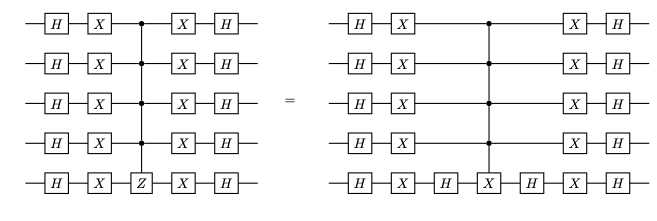

This operator computes the average mean of all state's amplitudes and flips each state probability over this mean. 

In [102]:
def diffusion(N, M, s): 

    c.add([gates.H(i) for i in range(N + M, N + M + s)])     
    c.add([gates.X(i) for i in range(N + M, N + M + s)])   
    c.add(gates.Z(N + M + s-1).controlled_by(*range(N + M, N + M + s-1)))
    c.add([gates.X(i) for i in range(N + M, N + M + s)])
    c.add([gates.H(i) for i in range(N + M, N + M + s)])
    
    return c


## Extra functions

Here we define some functions that will be used for solving this pattern matching problem. 

### Decimal to Binary 

This function takes as input the decimal number we need to convert to a binary number.  
First, it uses an integrated python function to convert the number into a binary string and then it removes first two digits "0b".

In [5]:
def bin_list(dec,nqubits): 
    binary = format(dec,'0{}b'.format(nqubits))
    return list(map(int, str(binary)))

### Binary to decimal 

There are two methods to convert a binary number into a decimal number and we will use the positional notation to convert them. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weights will be multiplying the digit corresponding to its binary number (0 or 1). Finally, we will sum up everything. 

Let's assume our binary number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find, and we will use this function to transform the state into a decimal number to find the inverting matrix classically. 

In [6]:
def bin_to_dec(binary_number):
    decimal_number = 0 #Initialize the number 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number

## Main code: Grover's algorithm for quantum pattern matching

The purpose of the program is to find the location (index) of the pattern $ |p\rangle = |10\rangle$ within the string $|w\rangle = |11100000\rangle$. 

In this section we apply Grover's algorithm for $N = 8$, $M = 2$ and $s = 3$. 

The steps to find the solution proceed as follows:
    
1. Asks which string do you want to use (for this code we have input $|w\rangle = |11100000\rangle$ as the string).
2. Creates the initial entangled state: 
<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ). $ </center>

<br>

3. Starts a loop running the whole Grover's algorithm (amplitude flip and amplification) 3 times to achieve maximum probability. The optimal number of times call each oracle for string matching is given by: 
<br>

<center> $k_{opt} = \sqrt{N + M -1}, $ </center>

<br>

4. Executes the circuit in order to find the result. 
5. Measures the state of the first three qubits which will correspond to the index of the string where the pattern can be found. 
6. Prints three columns corresponding to the state, the occurance of each state and their probability.

In [227]:
string_w = input("Given string: " )
string_w  = [int(x) for x in str(string_w)]
pattern_p = input("Pattern:  " )
pattern_p   = [int(x) for x in str(pattern_p )]

N = len(string_w)
M = len(pattern_p)

s = int(m.ceil(m.log2(N - M)))*M

#initialize 
c = Circuit(N + M + s)
initialize( N, M, s, string_w, pattern_p)

grovers_iter = m.ceil(m.sqrt(N + M - 1))
print("The Grover's oracle will be called", grovers_iter, "times")
if pattern_p[0] == pattern_p[1]:     
    for k in range(3): 
        if pattern_p[0] == 1:    
            oracle_1(N, M, s)
        else: 
            oracle_0(N, M, s)
else: 
    for k in range(grovers_iter):
        for p in pattern_p:
            if p == 1:
                oracle_1(N, M, s)
            else: 
                oracle_0(N, M, s)

c.add(gates.M(*range(N + M, N + M + int(s/2)), register_name="A"))
result = c(nshots=2000)
y = result.frequencies(binary=True, registers=True)

print('State', '\t\tOccurance','\tProbability')
for q_state in y['A']:
    print(q_state, '\t\t', y['A'][q_state],'\t\t',y['A'][q_state]/2000)

print()

max_key = max(y['A'].items(), key = operator.itemgetter(1))[0]
print("The pattern has been found at index i =",bin_to_dec(max_key))

Given string: 11101110
Pattern:  10
The Grover's oracle will be called 3 times
State 		Occurance 	Probability
000 		 221 		 0.1105
001 		 227 		 0.1135
010 		 295 		 0.1475
011 		 309 		 0.1545
100 		 219 		 0.1095
101 		 226 		 0.113
110 		 204 		 0.102
111 		 299 		 0.1495

The pattern has been found at index i = 3


# Plot

This plot shows probability vs all states available (created by 3 qubits). Notice that the one that has been measured with more frequency corresponds to the one we were searching for. We can see that the state with highest frequency is $|2\rangle$ meaning that the pattern $|p\rangle$ is located at index 2 of the string $|w\rangle$.

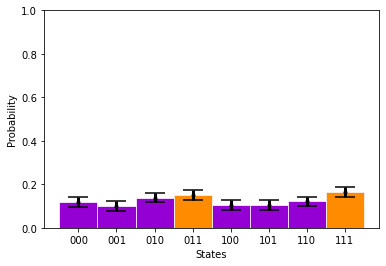

In [221]:
# FINDING STATE 
x = list(y['A'])
prob = [y['A'][el]/2000 for el in x] # elevating coeficients = probability 
y_error = 1/m.sqrt(2000)
fig, ax = plt.subplots()
 
ax.bar(x, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.bar(max_key, max(prob), width=1, edgecolor="white",color = "darkorange", linewidth=0.7)
ax.bar(x[3], prob[3], width=1, edgecolor="white",color = "darkorange", linewidth=0.7)

ax.set(ylim=(0, 1), xlabel = 'States', ylabel = 'Probability')
plt.errorbar(x, prob,  yerr=y_error, fmt = 'o', ms=3, color='black', elinewidth = 3, capsize = 10, capthick = 1.5)

plt.show()